# ODEs: Planetary motion

Here, we simulate planetary motion for the simple 2-body Kepler case, a planar 3-body case, and in a synodic reference frame. 

In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['legend.fancybox'] = True
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.optimize


## Kepler motion

In [2]:
params_kepler = {
    'tau':0.01,
    'accuracy':1e-6,
    'G_m1_plus_m2':1.0,
    'step_using_y':False,
    'method':'RK45',
    'tmax':200.,
    'r_aphelion':1.,  # in AU
    'eccentricity':0.0,
}

In [3]:
class Kepler :
    def __init__( self, params ):
        self.params=params
        for iparam,param in params.items():
            setattr(self, iparam, params[iparam])
        self.a = self.r_aphelion / (1 + self.eccentricity)
        self.vy0 = np.sqrt(self.G_m1_plus_m2 * (2 / self.r_aphelion - 1 / self.a))
    
    def set_param(self, parname, parval ):
        setattr( self, parname, parval )
        
    def __call__(self, t, p ) :        
        x = p[0]
        y = p[1]
        vx = p[2]
        vy = p[3]
        r = np.sqrt(x**2 + y**2)
        ax = - self.G_m1_plus_m2 * x / r**3
        ay = - self.G_m1_plus_m2 * y / r**3
        flow = np.array([ vx, vy, ax, ay ])
        if self.step_using_y:            # change independent variable from t to y
            flow = flow / vy
        return flow

In [4]:
kepler = Kepler(params_kepler)

res = scipy.integrate.solve_ivp(fun=kepler,t_span=(0,kepler.tmax),
                                y0=[kepler.r_aphelion, 0, 0, kepler.vy0], 
                                vectorized=True,
                                atol=1e-8,rtol=1e-6,
                                method=kepler.method,
                                first_step = 0.001)
t = res.t
states=res.y
x = states[0]
y = states[1]

Text(0, 0.5, 'y (AU)')

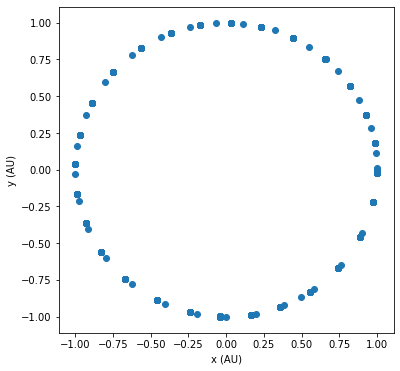

In [5]:
fig = plt.figure(1,figsize=(6,6))
plt.scatter(x,y)
plt.xlabel('x (AU)')
plt.ylabel('y (AU)')

## Planar 3-body motion

In [6]:
params_planar3body_earthmoonsun = {
    'tau':0.01,
    'accuracy':1e-6,
    'm1':0.012,
    'm2':1.0,
    'm3':330000.0,
    'method':'RK45',
    's1':np.array([0.0, 1.0027, 6.724, 0.0]),      # initial state for mass 1
    's2':np.array([0.0, 1.0,    6.5,   0.0]),      # initial state for mass 2
    's3':np.array([0.0, 0.0,    0,     0.0]),      # initial state for mass 3
    'tmax':1.27       # years
}

In [7]:
class Planar3Body :
    def __init__( self, params ):
        self.params=params
        for iparam,param in params.items():
            setattr(self, iparam, params[iparam])
        # use units such that G*(m1+m2+m3) = 4*pi**2
        self.G = 4 * np.pi**2 / (self.m1 + self.m2 + self.m3)

    def __call__(self, t, rv ) :
        ## This isn't technically necessary, but it makes the code a lot more readable. 
        x1 = rv[0] ; y1 = rv[1]  ;  vx1 = rv[2]  ;  vy1 = rv[3]
        x2 = rv[4] ; y2 = rv[5]  ;  vx2 = rv[6]  ;  vy2 = rv[7]
        x3 = rv[8] ; y3 = rv[9]  ;  vx3 = rv[10] ;  vy3 = rv[11]

        r12 = np.sqrt( (x1 - x2)**2 + (y1 - y2)**2 )
        r13 = np.sqrt( (x1 - x3)**2 + (y1 - y3)**2 )
        r23 = np.sqrt( (x2 - x3)**2 + (y2 - y3)**2 )

        ax1 = - self.G * self.m2 * (x1 - x2) / r12**3 - self.G * self.m3 * (x1 - x3) / r13**3
        ay1 = - self.G * self.m2 * (y1 - y2) / r12**3 - self.G * self.m3 * (y1 - y3) / r13**3

        ax2 = - self.G * self.m1 * (x2 - x1) / r12**3 - self.G * self.m3 * (x2 - x3) / r23**3
        ay2 = - self.G * self.m1 * (y2 - y1) / r12**3 - self.G * self.m3 * (y2 - y3) / r23**3

        ax3 = - self.G * self.m1 * (x3 - x1) / r13**3 - self.G * self.m2 * (x3 - x2) / r23**3
        ay3 = - self.G * self.m1 * (y3 - y1) / r13**3 - self.G * self.m2 * (y3 - y2) / r23**3
        return [vx1, vy1, ax1, ay1, vx2, vy2, ax2, ay2, vx3, vy3, ax3, ay3]




In [8]:
planar3body = Planar3Body(params_planar3body_earthmoonsun)

res = scipy.integrate.solve_ivp(fun=planar3body,t_span=(0,planar3body.tmax),
                                y0=np.concatenate( (planar3body.s1, planar3body.s2, planar3body.s3) ), 
                                vectorized=True,
                                atol=1e-8,rtol=1e-6,
                                method=kepler.method,
                                first_step = 0.001)
t = res.t
states=res.y
x1 = states[0]
y1 = states[1]
x2 = states[4]
y2 = states[5]
x3 = states[8]
y3 = states[9]

<IPython.core.display.Javascript object>


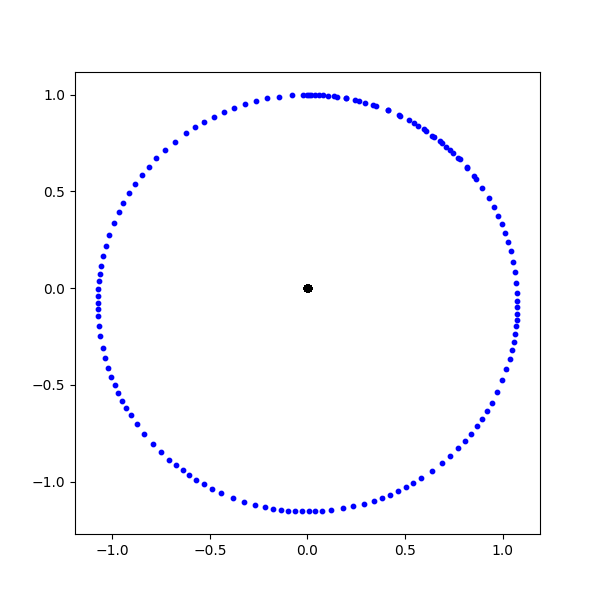

In [9]:
%matplotlib notebook
fig = plt.figure(2, figsize=(6,6))
plt.scatter(x1,y1, color='r', s=1)
plt.scatter(x2,y2, color='b', s=10)
plt.scatter(x3,y3, color='k', s=20)
plt.show()

## Restricted 3-body motion

In [10]:
params_rcp3body_chaotic = {
    'tau':0.01,
    'accuracy':1e-6,
    'a':0.25,
    'method':'RK45',
    's':np.array([-0.35, 0.0, 0.0, 0.5]),
    'tmax':10.
}

In [11]:
class Rcp3Body :
    # alpha = m2/(m1+m2) in the webnotes
    a = 0.0
    
    # switch to zero in on Poincare section point
    # use y instead of t as independent variable
    step_using_y = False
    def __init__(self, params ) :
        self.params=params
        for iparam,param in params.items():
            setattr(self, iparam, params[iparam])
        self.eps = 1e-6
        self.L = np.array( [
            [scipy.optimize.bisect( self.f_x, self.a - 1 + self.eps, self.a - self.eps ), 0.0],
            [scipy.optimize.bisect( self.f_x, -1.5,self.a - 1 - self.eps ), 0.0], 
            [scipy.optimize.bisect( self.f_x, self.a + self.eps, 1.5 ), 0.0],
            [self.a - 0.5,  np.sqrt(3.0) / 2 ], [self.a - 0.5, -np.sqrt(3.0) / 2 ] 
        ]
        )    
                
    def f_x(self, x):     
        '''
        effective x component of force on the x-axis
        '''
        return ( x - (1 - self.a) * (x - self.a) / np.abs(x - self.a) / (x - self.a)**2
                   - self.a * (x + 1 - self.a) / np.abs(x + 1 - self.a) / (x + 1 - self.a)**2 )
        
    def __call__(self, t, rv):         
        '''
        equations in co-rotating frame
        '''
        x = rv[0] ; y = rv[1] ; vx = rv[2] ; vy = rv[3]
        d1 = np.power( (x - self.a)**2 + y**2, 1.5 )
        d2 = np.power( (x + 1 - self.a)**2 + y**2, 1.5 )
        ax = - (1 - self.a) * (x - self.a) / d1 - self.a * (x + 1 -self.a) / d2 + x + 2 * vy
        ay = - (1 - self.a) * y / d1 - self.a * y / d2 + y - 2 * vx
        flow = [ vx, vy, ax, ay ]
        return flow

In [12]:
rcp3body = Rcp3Body(params_rcp3body_chaotic)

res = scipy.integrate.solve_ivp(fun=rcp3body,t_span=(0,rcp3body.tmax),
                                y0=rcp3body.s, 
                                vectorized=True,
                                atol=1e-8,rtol=1e-6,
                                method=kepler.method,
                                first_step = 0.001)
t = res.t
states=res.y
x = states[0]
y = states[1]
vx = states[2]
vy = states[3]



<IPython.core.display.Javascript object>


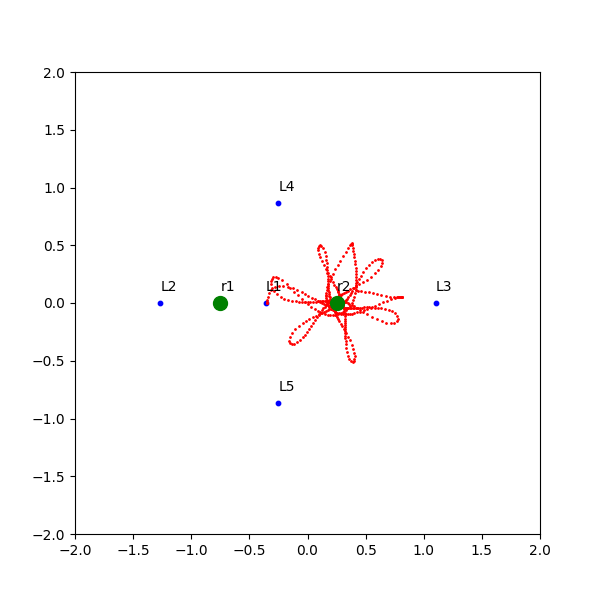

In [13]:

fig = plt.figure(3, figsize=(6,6))
plt.scatter(rcp3body.L[:,0], rcp3body.L[:,1], color='b', s=10)
plt.scatter(x,y, color='r', s=1)
plt.scatter([rcp3body.a-1], [0], color='g', s=100)
plt.scatter([rcp3body.a],   [0], color='g', s=100)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.annotate('r1',
            xy=(rcp3body.a-1, 0), xycoords='data',
            xytext=(rcp3body.a-1, 0.1), textcoords='data')
plt.annotate('r2',
            xy=(rcp3body.a, 0), xycoords='data',
            xytext=(rcp3body.a, 0.1), textcoords='data')
plt.annotate('L1',
            xy=rcp3body.L[0], xycoords='data',
            xytext=rcp3body.L[0]+np.array([0.0,0.1]), textcoords='data')
plt.annotate('L2',
            xy=rcp3body.L[1], xycoords='data',
            xytext=rcp3body.L[1]+np.array([0.0,0.1]), textcoords='data')
plt.annotate('L3',
            xy=rcp3body.L[2], xycoords='data',
            xytext=rcp3body.L[2]+np.array([0.0,0.1]), textcoords='data')
plt.annotate('L4',
            xy=rcp3body.L[3], xycoords='data',
            xytext=rcp3body.L[3]+np.array([0.0,0.1]), textcoords='data')
plt.annotate('L5',
            xy=rcp3body.L[4], xycoords='data',
            xytext=rcp3body.L[4]+np.array([0.0,0.1]), textcoords='data')

plt.show()